In [1]:
import pandas as pd
import numpy as np
import NB_Funcs as hlp
from scipy.ndimage import convolve
from matplotlib import pyplot as plt
import pickle

# Autocorrelated S Model

$ \frac{dN}{dt} = r*N*S $

$ \frac{dS}{dt} = -\nu*\frac{dN}{dt} $

Where inital S is determined based on ring value

Solution $S(t)$ is as follows:

$S(t) = S_0*e^{\int_0^tr*\nu^t*N(t)dt}$

In [2]:
S = np.load('../data/RawData/ACS/ACS_S_curves.npy')
N = np.load('../data/RawData/ACS/ACS_N_curves.npy')

N_stnd = np.array(N, copy = True)
dt = 0.1
time = np.arange(N.shape[1])*dt
t = N.shape[1]
plates = N.shape[0]
rows = N.shape[2]
cols = N.shape[3]

plate_maximums = {}

for p in range(plates):
    plate_maximums[p] = np.max(N[p,:,:,:])
    N_stnd[p,:,:,:] = N_stnd[p,:,:,:] / np.max(N[p,:,:,:])

print(S.shape)
print(N.shape)
print(N_stnd.shape)

(4, 400, 32, 48)
(4, 400, 32, 48)
(4, 400, 32, 48)


In [3]:
S_inits = np.empty((rows,cols))

for i in range(rows):
    for j in range(cols):
        S_inits[i,j] = S[0,0,i,j]
    

# Visualizing Population and Nutrient Curves

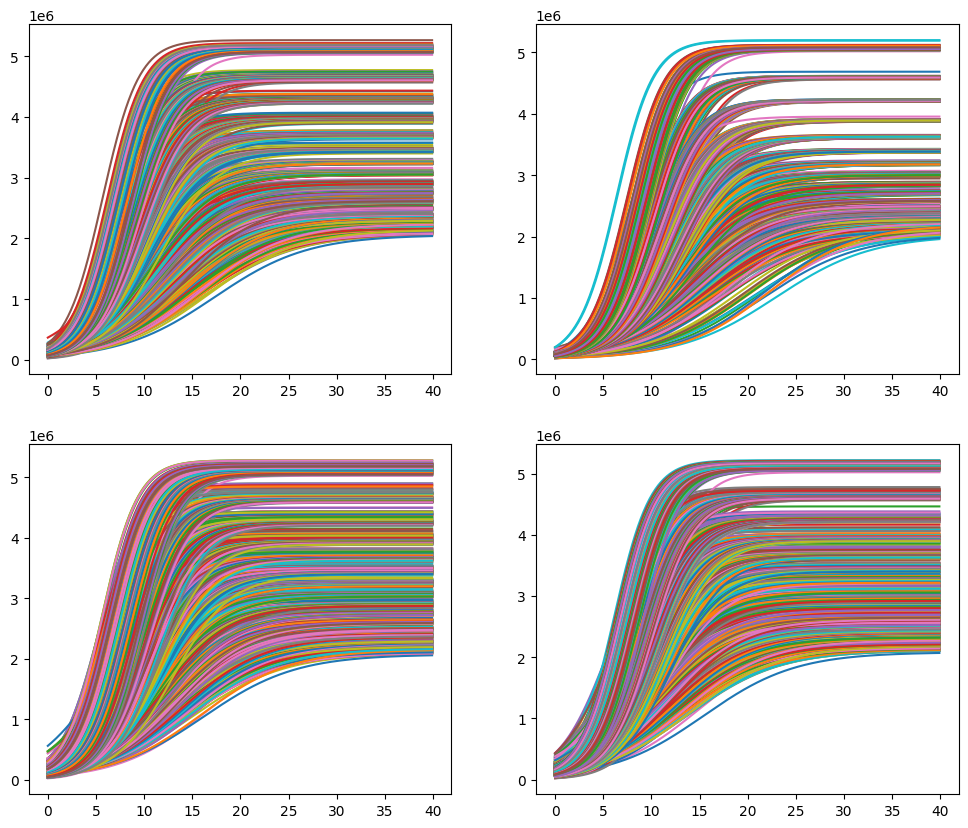

In [5]:
#Plotting all Population curves for all plates

fig, axs = plt.subplots(2,2,figsize = (12,10))

for i in range(rows):
    for j in range(cols):
        axs[0,0].plot(time,N[0,:,i,j])

for i in range(rows):
    for j in range(cols):
        axs[0,1].plot(time,N[1,:,i,j])
        
for i in range(rows):
    for j in range(cols):
        axs[1,0].plot(time,N[2,:,i,j])
        
for i in range(rows):
    for j in range(cols):
        axs[1,1].plot(time,N[3,:,i,j])  

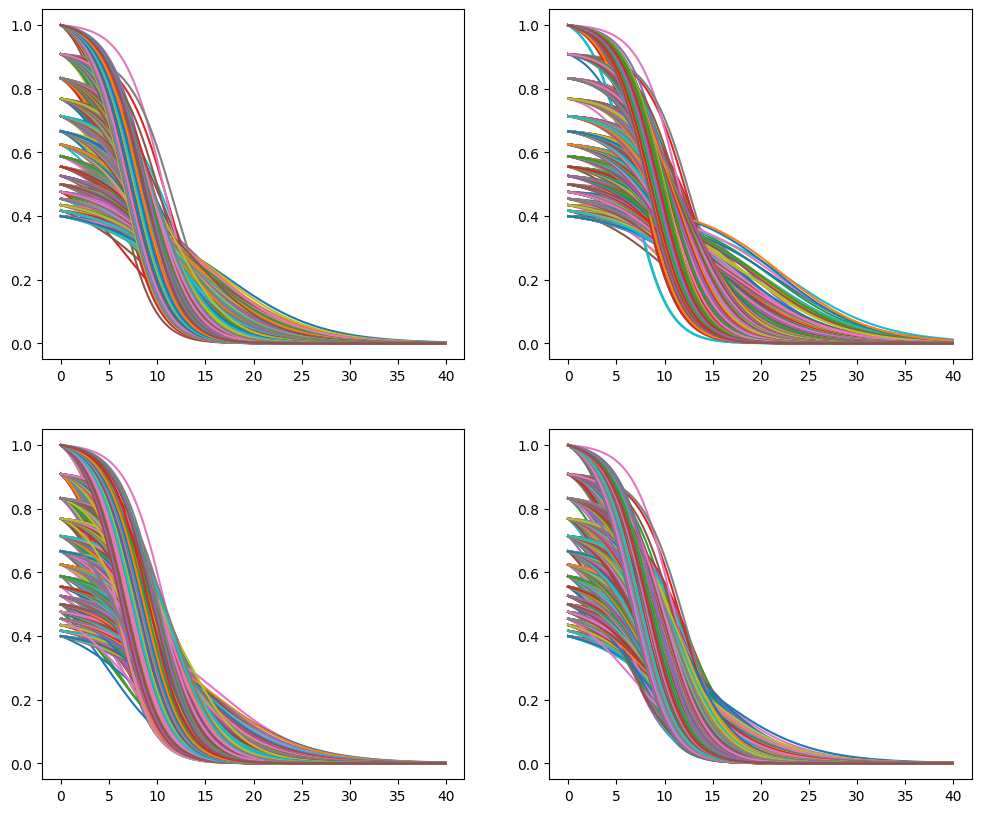

In [6]:
#Plotting all Nutrient curves for all plates

fig, axs = plt.subplots(2,2,figsize = (12,10))

for i in range(rows):
    for j in range(cols):
        axs[0,0].plot(time,S[0,:,i,j])

for i in range(rows):
    for j in range(cols):
        axs[0,1].plot(time,S[1,:,i,j])
        
for i in range(rows):
    for j in range(cols):
        axs[1,0].plot(time,S[2,:,i,j])
        
for i in range(rows):
    for j in range(cols):
        axs[1,1].plot(time,S[3,:,i,j])  

In [7]:
# 32x48 array of ring value
rings = np.empty((rows,cols))

edge_r = (0,rows-1)
edge_c = (0,cols-1)

for i in range(rows):
    for j in range(cols):
        
        rings[i,j] = min(abs(i-edge_r[0])+1,abs(i-edge_r[1])+1,
                             abs(j-edge_c[0])+1,abs(j-edge_c[1])+1)

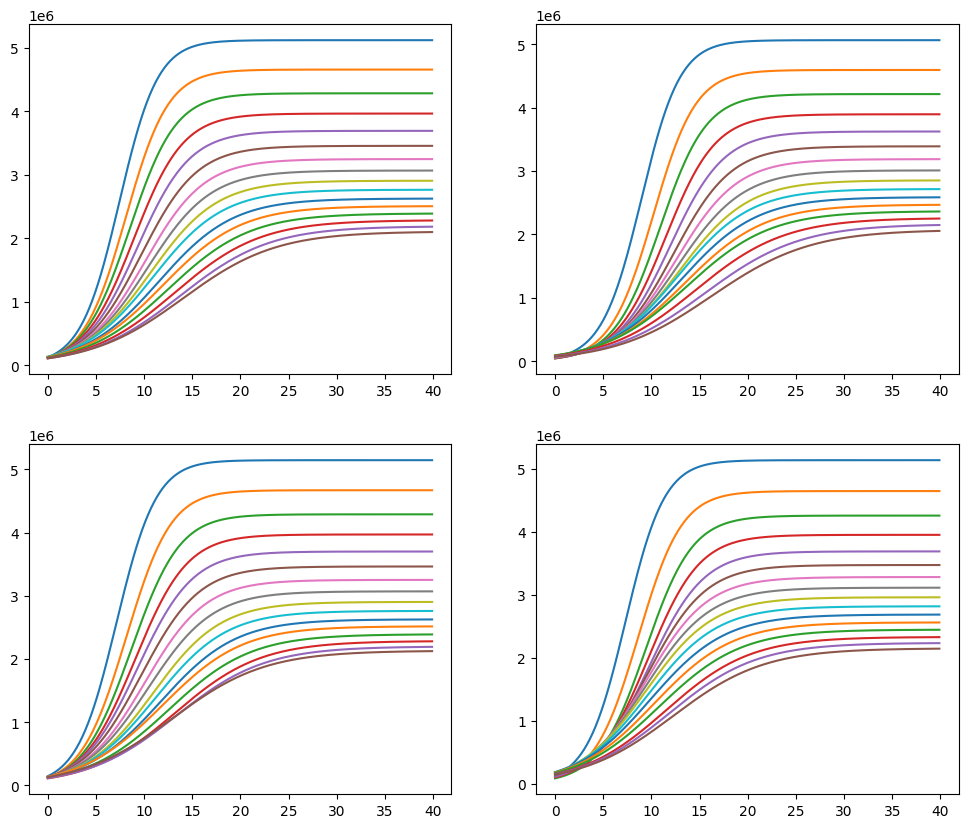

In [8]:
# Here compute average N for each Ring and plot them
ring_list = np.arange(rings.min(),rings.max()+1)
ring_averages_N = np.zeros((plates,t,len(ring_list)))
ring_averages_S = np.zeros((plates,t,len(ring_list)))

for p in range(plates):
    for ring_val in ring_list:
        for k in range(t):
            mask = np.where(rings == ring_val)
            ring_averages_N[p,k,int(ring_val-1)] = np.mean(N[p,k,:,:][mask])
            ring_averages_S[p,k,int(ring_val-1)] = np.mean(S[p,k,:,:][mask])

fig, axs = plt.subplots(2,2,figsize=(12,10))

for i in range(16):
    axs[0,0].plot(time,ring_averages_N[0,:,i])

for i in range(16):
    axs[0,1].plot(time,ring_averages_N[1,:,i])

for i in range(16):
    axs[1,0].plot(time,ring_averages_N[2,:,i])
    
for i in range(16):
    axs[1,1].plot(time,ring_averages_N[3,:,i])

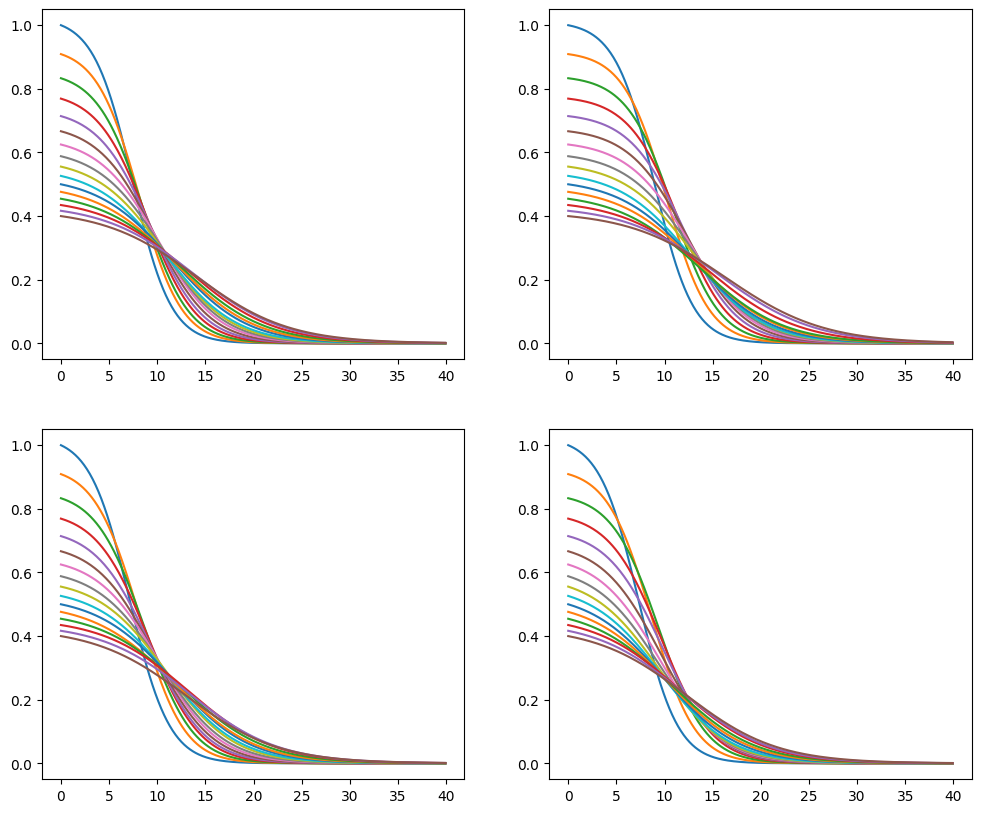

In [9]:
fig, axs = plt.subplots(2,2,figsize=(12,10))

for i in range(16):
    axs[0,0].plot(time,ring_averages_S[0,:,i])

for i in range(16):
    axs[0,1].plot(time,ring_averages_S[1,:,i])

for i in range(16):
    axs[1,0].plot(time,ring_averages_S[2,:,i])
    
for i in range(16):
    axs[1,1].plot(time,ring_averages_S[3,:,i])

# Preprocessing

In [10]:
#2 different ways of storing the data, ring format and colony format

ring_form_data = {}

colony_form_data = {}

## Colony Format

In [11]:
for p in range(plates):
    colony_form_data[p] = []
    
    for i in range(rows):
        for j in range(cols):
            Ps = np.ones((t)) * p
            Is = np.ones((t)) * i
            Js = np.ones((t)) * j
            N_ = N[p,:,i,j]
            N_init = np.ones((t)) * N[p,0,i,j]
            S_ = S[p,:,i,j]
            S_init = np.ones((t)) * S[p,0,i,j]
            N_init_stnd = np.ones((t)) * N_stnd[p,0,i,j]
            N_s = N_stnd[p,:,i,j]
            
            data = np.vstack([time,Ps,Is,Js,N_,N_s,S_,N_init,N_init_stnd,S_init]).T
            df = pd.DataFrame(data = data, columns = ["time","plate","i","j","Pop","Pop_stnd","Nutr","N_init",
                                                      "N_init_stnd","Nutr_Init"])
            
            if j == 0:
                colony_form_data[p].append([df])
            else: colony_form_data[p][i].append(df)
            
for p in range(plates):
    dNdt = hlp.cubic_splines(N[p],time)
    dNdt_stnd = hlp.cubic_splines(N_stnd[p],time)
    dSdt = hlp.cubic_splines(S[p],time)
    for i in range(rows):
        for j in range(cols):
            colony_form_data[p][i][j]['dNdt'] = dNdt[:,i,j]
            colony_form_data[p][i][j]['dNdt_stnd'] = dNdt_stnd[:,i,j]
            colony_form_data[p][i][j]['dSdt'] = dSdt[:,i,j]

for p in range(plates):
    Nbar = np.empty((t,rows,cols))
    Sbar = np.empty((t,rows,cols))
    
    kernel = np.array([[1,1,1],
                       [1,0,1],
                       [1,1,1]])
    
    for tic in range(t):

        sums = convolve(N[p,tic,:,:],kernel,mode='constant')
        sums_s = convolve(S[p,tic,:,:],kernel,mode='constant')
        
        Nbar[tic,:,:] = sums / 8
        Sbar[tic,:,:] = sums_s / 8

    for i in range(rows):
        for j in range(cols):
            colony_form_data[p][i][j]['Sbar'] = Sbar[:,i,j]
            
            colony_form_data[p][i][j]['Nbar'] = Nbar[:,i,j]
            colony_form_data[p][i][j]['Cum_Nbar'] = np.cumsum(Nbar[:,i,j])*dt
            colony_form_data[p][i][j]['Cum_N'] = np.cumsum(N[p,:,i,j])*dt
            
            colony_form_data[p][i][j]['Nbar_stnd'] = Nbar[:,i,j] / np.max(N)
            colony_form_data[p][i][j]['Cum_Nbar_stnd'] = np.cumsum(Nbar[:,i,j])*dt / np.max(N)
            colony_form_data[p][i][j]['Cum_N_stnd'] = np.cumsum(N[p,:,i,j])*dt / np.max(N)

for p in range(plates):
    for i in range(rows):
        for df in colony_form_data[p][i]:
            df['dNovN'] = df['dNdt'] / df['Pop']
            df['dNovN_stnd'] = df['dNdt_stnd'] / df['Pop_stnd']

for p in range(plates):
    for i in range(rows):
        for j in range(cols):
            colony_form_data[p][i][j]['Ring'] = np.ones((t)) * rings[i,j]
    
colony_form_data[0][0][0].head(3)

,time,plate,i,j,Pop,Pop_stnd,Nutr,N_init,N_init_stnd,Nutr_Init,...,Sbar,Nbar,Cum_Nbar,Cum_N,Nbar_stnd,Cum_Nbar_stnd,Cum_N_stnd,dNovN,dNovN_stnd,Ring
0,0.0,0.0,0.0,0.0,122705.342189,0.023295,1.000000,122705.342189,0.023295,1.0,...,0.363636,45512.986141,4551.298614,12270.534219,0.008617,0.000862,0.002323,0.488192,0.488192,1.0
1,0.1,0.0,0.0,0.0,128840.609299,0.024460,0.998773,122705.342189,0.023295,1.0,...,0.363196,47715.062816,9322.804896,25154.595149,0.009034,0.001765,0.004763,0.487612,0.487612,1.0
2,0.2,0.0,0.0,0.0,135274.735048,0.025681,0.997486,122705.342189,0.023295,1.0,...,0.362735,50021.095739,14324.914470,38682.068654,0.009471,0.002712,0.007324,0.487016,0.487016,1.0


## Ring Format

In [12]:
for p in range(plates):
    checklist = {}
    for i in range(rows):
        for df in colony_form_data[p][i]:
            ring_val = df['Ring'][0]
            if ring_val in checklist:
                checklist[ring_val].append(df)
            else:
                checklist[ring_val] = [df]
    
    ring_form_data[p] = checklist
    
print(len(ring_form_data[0][16]))
ring_form_data[0][1][0].head(3)

36


,time,plate,i,j,Pop,Pop_stnd,Nutr,N_init,N_init_stnd,Nutr_Init,...,Sbar,Nbar,Cum_Nbar,Cum_N,Nbar_stnd,Cum_Nbar_stnd,Cum_N_stnd,dNovN,dNovN_stnd,Ring
0,0.0,0.0,0.0,0.0,122705.342189,0.023295,1.000000,122705.342189,0.023295,1.0,...,0.363636,45512.986141,4551.298614,12270.534219,0.008617,0.000862,0.002323,0.488192,0.488192,1.0
1,0.1,0.0,0.0,0.0,128840.609299,0.024460,0.998773,122705.342189,0.023295,1.0,...,0.363196,47715.062816,9322.804896,25154.595149,0.009034,0.001765,0.004763,0.487612,0.487612,1.0
2,0.2,0.0,0.0,0.0,135274.735048,0.025681,0.997486,122705.342189,0.023295,1.0,...,0.362735,50021.095739,14324.914470,38682.068654,0.009471,0.002712,0.007324,0.487016,0.487016,1.0


## Functions for Storing and Loading Results

In [14]:
hlp.pickle_save('../Data/Train_Test/ACS_PreprocessedData',(colony_form_data,ring_form_data,plate_maximums))